In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
import keras
from keras.layers import ConvLSTM2D
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import save_model
from keras.models import load_model
from keras.utils import plot_model

In [ ]:
df = pd.read_csv('Denoised.csv',index_col='Date',parse_dates=True)
df = df.interpolate()

In [ ]:
df[df < 0] = 0

In [ ]:
df.head()

,temp_min,temp_max,humidity_min,humidity_max,wind_speed_max,heat_w
Date,,,,,,
2018-01-01,13.468043,33.161490,32.163340,47.911526,2.834704,False
2018-01-02,13.287754,34.131336,36.827880,45.916138,2.106622,False
2018-01-03,12.861378,33.059510,37.971767,55.520905,3.508370,False
2018-01-04,11.801758,33.292366,33.286045,61.322166,0.962410,False
2018-01-05,12.187715,32.869610,31.685131,53.466194,2.627481,False


Text(0.5, 1.0, 'Wind Speed Max')

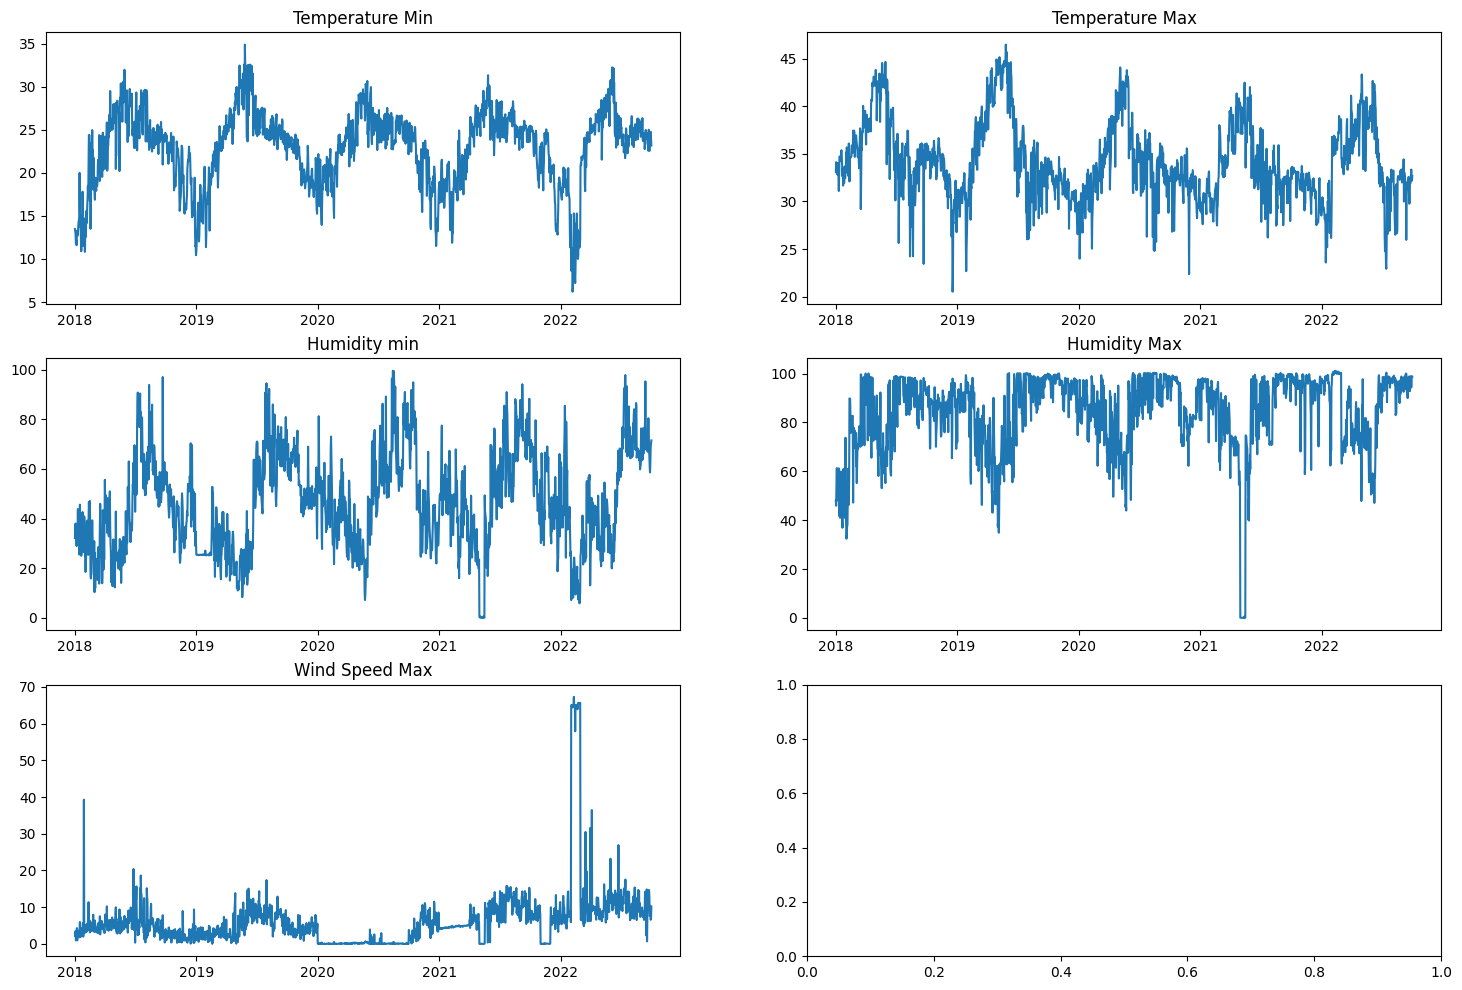

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
figure, axis = plt.subplots(3, 2)

axis[0,0].plot(df['temp_min'])
axis[0,0].set_title("Temperature Min")

axis[0,1].plot(df['temp_max'])
axis[0,1].set_title("Temperature Max")

axis[1,0].plot(df['humidity_min'])
axis[1,0].set_title("Humidity min")

axis[1,1].plot(df['humidity_max'])
axis[1,1].set_title("Humidity Max")

axis[2,0].plot(df['wind_speed_max'])
axis[2,0].set_title("Wind Speed Max")

In [ ]:
df_mint = df['temp_min'].values
df_mint = df_mint.astype('float32')
df_mint = df_mint.reshape(-1,1)

df_maxt = df['temp_max'].values
df_maxt = df_maxt.astype('float32')
df_maxt = df_maxt.reshape(-1,1)

df_minh = df['humidity_min'].values
df_minh = df_minh.astype('float32')
df_minh = df_minh.reshape(-1,1)

df_maxh = df['humidity_max'].values
df_maxh = df_maxh.astype('float32')
df_maxh = df_maxh.reshape(-1,1)

df_maxw = df['wind_speed_max'].values
df_maxw = df_maxw.astype('float32')
df_maxw = df_maxw.reshape(-1,1)

In [ ]:
def to_sequences(dataset,seq_size=1):
  x=[]
  y=[]
  for i in range(len(dataset)-seq_size-1):
    window = dataset[i:(i+seq_size),0]
    x.append(window)
    y.append(dataset[i+seq_size,0])
  return np.array(x),np.array(y)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_mint = scaler.fit_transform(np.array(df_mint.reshape(-1,1)))
train_size = int(len(df_mint)*0.60)
test_size = len(df_mint)-train_size
mint_train,mint_test = df_mint[0:train_size],df_mint[train_size:len(df_mint)]


seq_size = 150
mint_trainX=[]
mint_testX=[]

In [ ]:
mint_trainX,mint_y_train = to_sequences(mint_train,seq_size)
mint_testX,mint_y_test = to_sequences(mint_test,seq_size)

mint_X_train = np.reshape(mint_trainX,(mint_trainX.shape[0],1,mint_trainX.shape[1]))
mint_X_test = np.reshape(mint_testX,(mint_testX.shape[0],1,mint_testX.shape[1]))

In [ ]:
n_future = 1
feature = 2
timeSteps = 4

mint_model = Sequential()
mint_model.add(Bidirectional(LSTM(units=50,return_sequences=True,
                             input_shape=(mint_X_train.shape[1],1))))
mint_model.add(LSTM(units=50,return_sequences=True))
mint_model.add(Dropout(0.2))
mint_model.add(LSTM(units=50,return_sequences=True))
mint_model.add(Dropout(0.2))
mint_model.add(LSTM(units=50))
mint_model.add(Dropout(0.2))
mint_model.add(Dense(units=n_future))


mint_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])

In [ ]:
mint_model.fit(mint_X_train,mint_y_train,epochs=500)

Epoch 1/500
28/28 [==============================] - 17s 10ms/step - loss: 0.1986 - acc: 0.0000e+00
Epoch 2/500
28/28 [==============================] - 0s 12ms/step - loss: 0.0273 - acc: 0.0000e+00
Epoch 3/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0242 - acc: 0.0000e+00
Epoch 4/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0222 - acc: 0.0000e+00
Epoch 5/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0182 - acc: 0.0000e+00
Epoch 6/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0120 - acc: 0.0000e+00
Epoch 7/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0112 - acc: 0.0000e+00
Epoch 8/500
28/28 [==============================] - 0s 13ms/step - loss: 0.0099 - acc: 0.0000e+00
Epoch 9/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0097 - acc: 0.0000e+00
Epoch 10/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0085 - acc: 0.0000e+00
Epoch 11

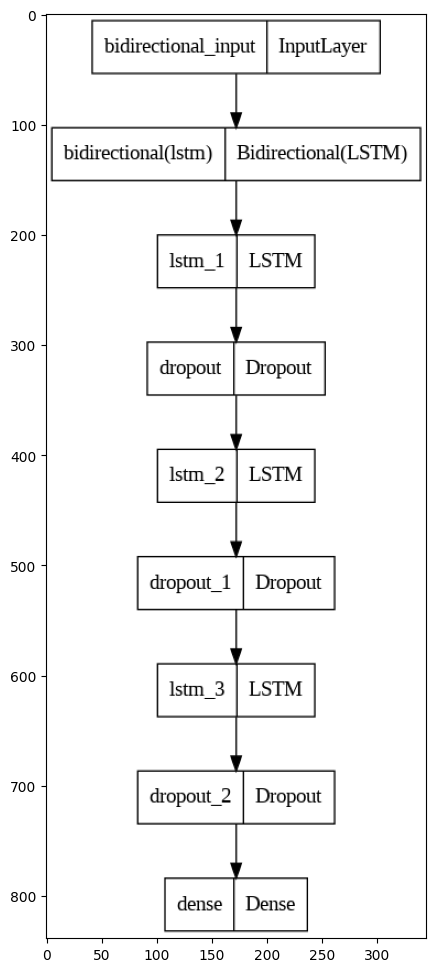

In [ ]:
plot_model(mint_model,to_file='mint_model.png')
img=plt.imread('mint_model.png')
plt.imshow(img)
plt.show()

In [ ]:
#make Predictions
mint_trainPredict = mint_model.predict(mint_X_train)
mint_testPredict = mint_model.predict(mint_X_test)
#invert predictions
mint_trainPredict = scaler.inverse_transform(mint_trainPredict)
mint_trainY = scaler.inverse_transform([mint_y_train])
mint_testPredict = scaler.inverse_transform(mint_testPredict)
mint_testY = scaler.inverse_transform([mint_y_test])

17/17 [==============================] - 0s 7ms/step


In [ ]:
mint_trainY = scaler.inverse_transform(mint_y_train.reshape(-1,1))
mint_testY = scaler.inverse_transform(mint_y_test.reshape(-1,1))

In [ ]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(mint_trainY,mint_trainPredict))
print('Train Score:%.2f RMSE'%(trainScore))

testScore = math.sqrt(mean_squared_error(mint_testY,mint_testPredict))
print('TestScore:%.2f RMSE'%(testScore))

Train Score:1.17 RMSE
TestScore:2.20 RMSE


In [ ]:
#shift train predictions for plotting
mint_trainPredictPlot = np.empty_like(df_mint)
mint_trainPredictPlot[:,:] = np.nan
mint_trainPredictPlot[seq_size:len(mint_trainPredict)+seq_size,:] = mint_trainPredict
#shift test predictions for plotting
mint_testPredictPlot = np.empty_like(df_mint)
mint_testPredictPlot[:,:] = np.nan
mint_testPredictPlot[len(mint_trainPredict)+(seq_size*2)+1:len(df_mint)-1,:] = mint_testPredict


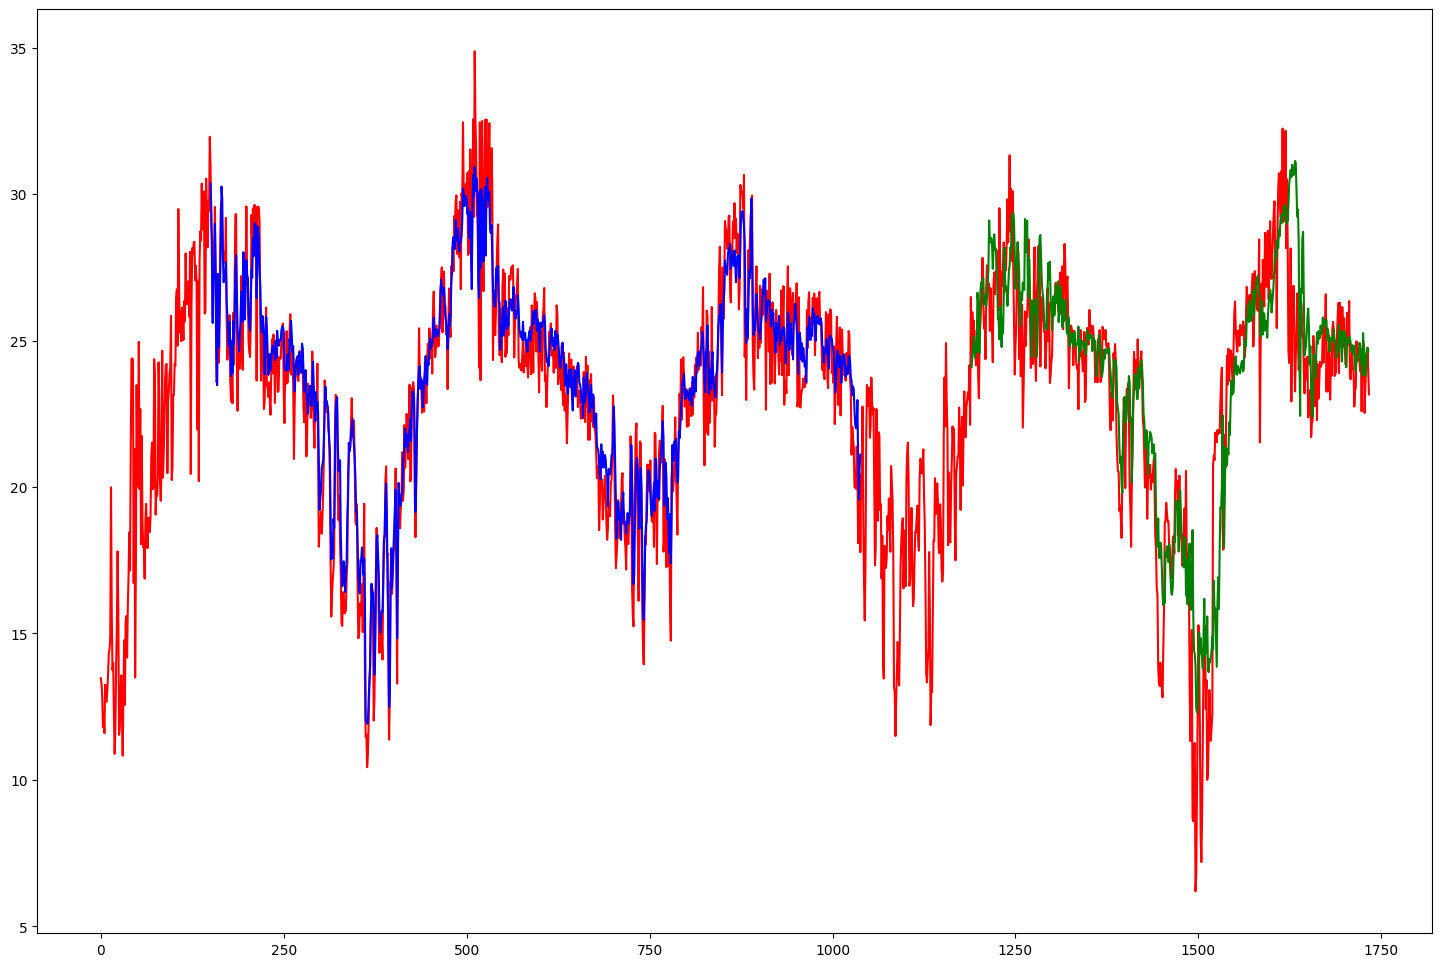

In [ ]:
plt.plot(scaler.inverse_transform(df_mint),color='red')
plt.plot(mint_trainPredictPlot,color='blue')
plt.plot(mint_testPredictPlot,color='green')
plt.show()

**MAXIMUM** **TEMPERATURE**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_maxt = scaler.fit_transform(np.array(df_maxt.reshape(-1,1)))
train_size = int(len(df_maxt)*0.60)
test_size = len(df_maxt)-train_size
maxt_train,maxt_test = df_maxt[0:train_size],df_maxt[train_size:len(df_maxt)]


seq_size = 150
maxt_trainX=[]
maxt_testX=[]

In [ ]:
maxt_trainX,maxt_y_train = to_sequences(maxt_train,seq_size)
maxt_testX,maxt_y_test = to_sequences(maxt_test,seq_size)

maxt_X_train = np.reshape(maxt_trainX,(maxt_trainX.shape[0],1,maxt_trainX.shape[1]))
maxt_X_test = np.reshape(maxt_testX,(maxt_testX.shape[0],1,maxt_testX.shape[1]))

In [ ]:
n_future = 1
feature = 2
timeSteps = 4

maxt_model = Sequential()
maxt_model.add(Bidirectional(LSTM(units=50,return_sequences=True,
                             input_shape=(maxt_X_train.shape[1],1))))
maxt_model.add(LSTM(units=50,return_sequences=True))
maxt_model.add(Dropout(0.2))
maxt_model.add(LSTM(units=50,return_sequences=True))
maxt_model.add(Dropout(0.2))
maxt_model.add(LSTM(units=50))
maxt_model.add(Dropout(0.2))
maxt_model.add(Dense(units=n_future))


maxt_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])

In [ ]:
maxt_model.fit(maxt_X_train,maxt_y_train,epochs=500)

Epoch 1/500
28/28 [==============================] - 10s 11ms/step - loss: 0.1612 - acc: 0.0011
Epoch 2/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0361 - acc: 0.0011
Epoch 3/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0305 - acc: 0.0011
Epoch 4/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0234 - acc: 0.0022
Epoch 5/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0166 - acc: 0.0022
Epoch 6/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0148 - acc: 0.0022
Epoch 7/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0161 - acc: 0.0011
Epoch 8/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0142 - acc: 0.0022
Epoch 9/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0131 - acc: 0.0022
Epoch 10/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0131 - acc: 0.0022
Epoch 11/500
28/28 [============================

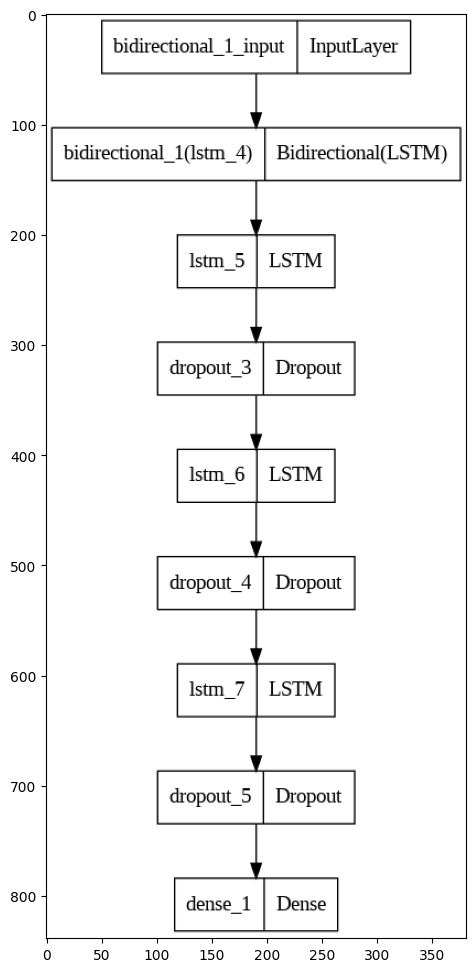

In [ ]:
plot_model(maxt_model,to_file='maxt_model.png')
img=plt.imread('maxt_model.png')
plt.imshow(img)
plt.show()

In [ ]:
#make Predictions
maxt_trainPredict = maxt_model.predict(maxt_X_train)
maxt_testPredict = maxt_model.predict(maxt_X_test)
#invert predictions
maxt_trainPredict = scaler.inverse_transform(maxt_trainPredict)
maxt_trainY = scaler.inverse_transform([maxt_y_train])
maxt_testPredict = scaler.inverse_transform(maxt_testPredict)
maxt_testY = scaler.inverse_transform([maxt_y_test])

17/17 [==============================] - 0s 6ms/step


In [ ]:
maxt_trainY = scaler.inverse_transform(maxt_y_train.reshape(-1,1))
maxt_testY = scaler.inverse_transform(maxt_y_test.reshape(-1,1))

In [ ]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(maxt_trainY,maxt_trainPredict))
print('Train Score:%.2f RMSE'%(trainScore))

testScore = math.sqrt(mean_squared_error(maxt_testY,maxt_testPredict))
print('TestScore:%.2f RMSE'%(testScore))

Train Score:1.04 RMSE
TestScore:2.56 RMSE


In [ ]:
#shift train predictions for plotting
maxt_trainPredictPlot = np.empty_like(df_maxt)
maxt_trainPredictPlot[:,:] = np.nan
maxt_trainPredictPlot[seq_size:len(maxt_trainPredict)+seq_size,:] = maxt_trainPredict
#shift test predictions for plotting
maxt_testPredictPlot = np.empty_like(df_maxt)
maxt_testPredictPlot[:,:] = np.nan
maxt_testPredictPlot[len(maxt_trainPredict)+(seq_size*2)+1:len(df_maxt)-1,:] = maxt_testPredict

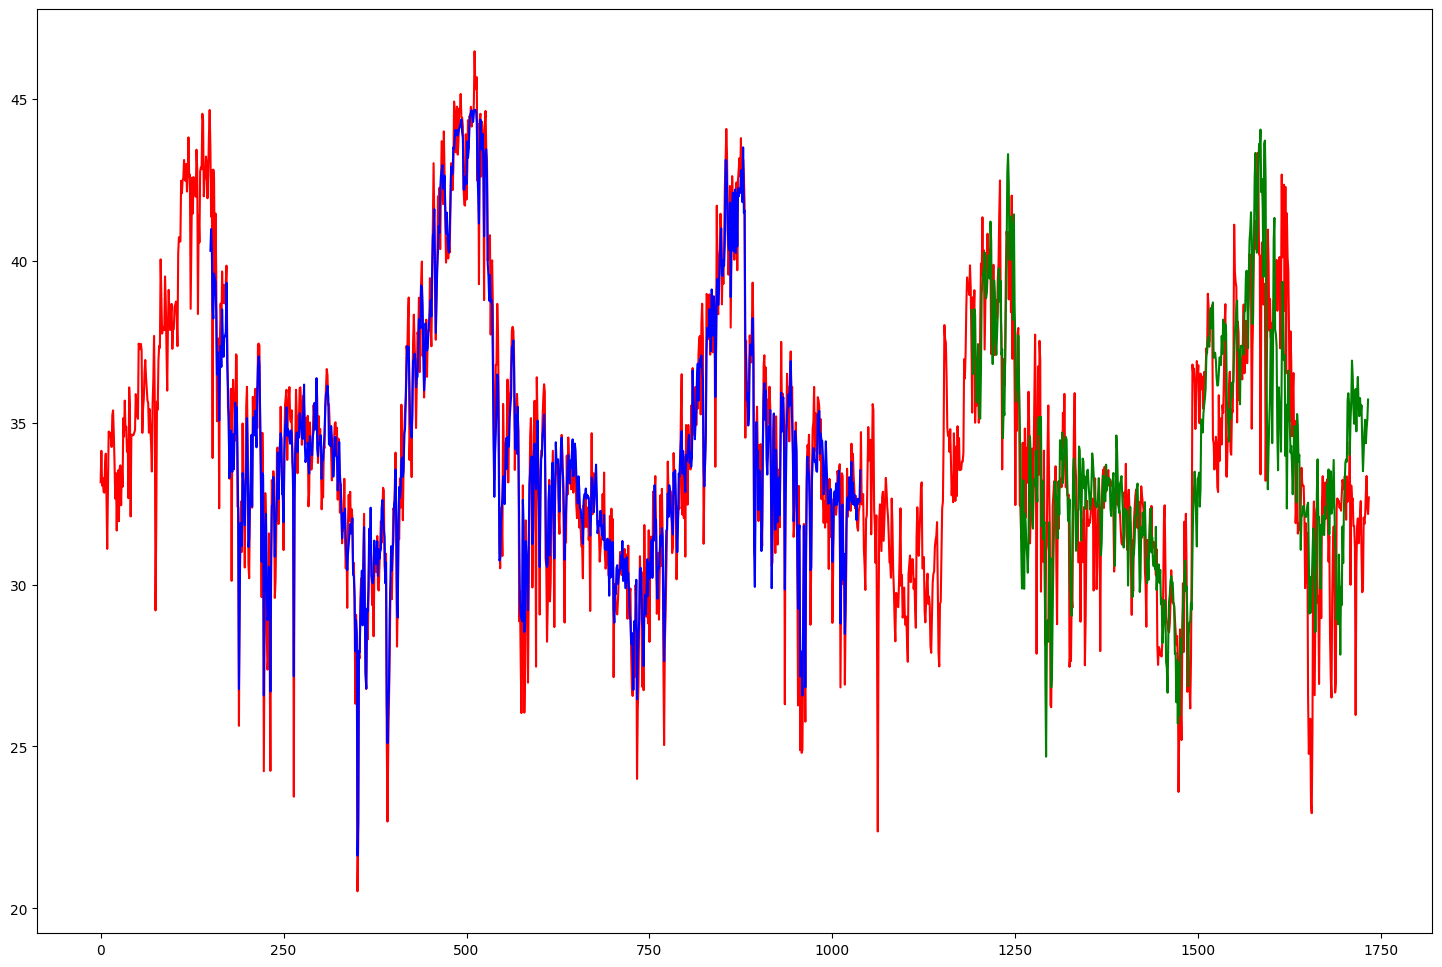

In [ ]:
plt.plot(scaler.inverse_transform(df_maxt),color='red')
plt.plot(maxt_trainPredictPlot,color='blue')
plt.plot(maxt_testPredictPlot,color='green')
plt.show()

**MINIMUM** **HUMIDITY**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_minh = scaler.fit_transform(np.array(df_minh.reshape(-1,1)))
train_size = int(len(df_minh)*0.60)
test_size = len(df_minh)-train_size
minh_train,minh_test = df_minh[0:train_size],df_minh[train_size:len(df_minh)]


seq_size = 150
minh_trainX=[]
minh_testX=[]

In [ ]:
minh_trainX,minh_y_train = to_sequences(minh_train,seq_size)
minh_testX,minh_y_test = to_sequences(minh_test,seq_size)

minh_X_train = np.reshape(minh_trainX,(minh_trainX.shape[0],1,minh_trainX.shape[1]))
minh_X_test = np.reshape(minh_testX,(minh_testX.shape[0],1,minh_testX.shape[1]))

In [ ]:
n_future = 1
feature = 2
timeSteps = 4

minh_model = Sequential()
minh_model.add(Bidirectional(LSTM(units=50,return_sequences=True,
                             input_shape=(minh_X_train.shape[1],1))))
minh_model.add(LSTM(units=50,return_sequences=True))
minh_model.add(Dropout(0.2))
minh_model.add(LSTM(units=50,return_sequences=True))
minh_model.add(Dropout(0.2))
minh_model.add(LSTM(units=50))
minh_model.add(Dropout(0.2))
minh_model.add(Dense(units=n_future))


minh_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])

In [ ]:
minh_model.fit(minh_X_train,minh_y_train,epochs=500)

Epoch 1/500
28/28 [==============================] - 10s 11ms/step - loss: 0.1410 - acc: 0.0000e+00
Epoch 2/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0383 - acc: 0.0000e+00
Epoch 3/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0301 - acc: 0.0011
Epoch 4/500
28/28 [==============================] - 0s 12ms/step - loss: 0.0193 - acc: 0.0011
Epoch 5/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0166 - acc: 0.0011
Epoch 6/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0176 - acc: 0.0011
Epoch 7/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0138 - acc: 0.0011
Epoch 8/500
28/28 [==============================] - 0s 10ms/step - loss: 0.0150 - acc: 0.0011
Epoch 9/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0149 - acc: 0.0011
Epoch 10/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0140 - acc: 0.0011
Epoch 11/500
28/28 [====================

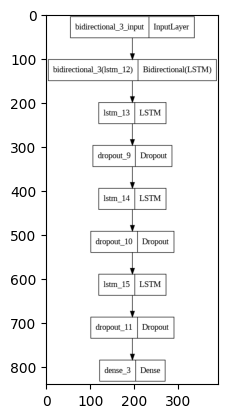

In [ ]:
plot_model(minh_model,to_file='minh_model.png')
img=plt.imread('minh_model.png')
plt.imshow(img)
plt.show()

In [ ]:
#make Predictions
minh_trainPredict = minh_model.predict(minh_X_train)
minh_testPredict = minh_model.predict(minh_X_test)
#invert predictions
minh_trainPredict = scaler.inverse_transform(minh_trainPredict)
minh_trainY = scaler.inverse_transform([minh_y_train])
minh_testPredict = scaler.inverse_transform(minh_testPredict)
minh_testY = scaler.inverse_transform([minh_y_test])

17/17 [==============================] - 0s 4ms/step


In [ ]:
minh_trainY = scaler.inverse_transform(minh_y_train.reshape(-1,1))
minh_testY = scaler.inverse_transform(minh_y_test.reshape(-1,1))

In [ ]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(minh_trainY,minh_trainPredict))
print('Train Score:%.2f RMSE'%(trainScore))

testScore = math.sqrt(mean_squared_error(minh_testY,minh_testPredict))
print('TestScore:%.2f RMSE'%(testScore))

Train Score:2.46 RMSE
TestScore:13.99 RMSE


In [ ]:
#shift train predictions for plotting
minh_trainPredictPlot = np.empty_like(df_minh)
minh_trainPredictPlot[:,:] = np.nan
minh_trainPredictPlot[seq_size:len(minh_trainPredict)+seq_size,:] = minh_trainPredict
#shift test predictions for plotting
minh_testPredictPlot = np.empty_like(df_minh)
minh_testPredictPlot[:,:] = np.nan
minh_testPredictPlot[len(minh_trainPredict)+(seq_size*2)+1:len(df_minh)-1,:] = minh_testPredict

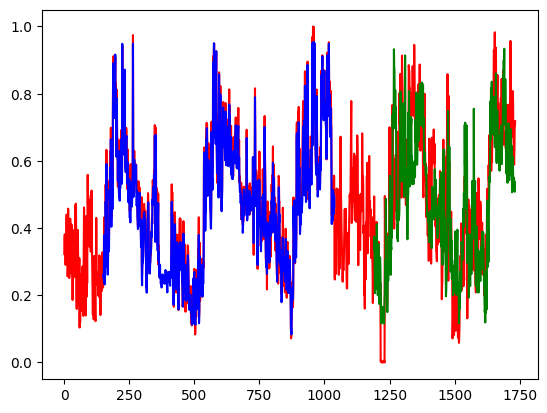

In [ ]:
plt.plot(scaler.inverse_transform(df_minh),color='red')
plt.plot(minh_trainPredictPlot,color='blue')
plt.plot(minh_testPredictPlot,color='green')
plt.show()

**MAXIMUM** **HUMIDITY**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_maxh = scaler.fit_transform(np.array(df_maxh.reshape(-1,1)))
train_size = int(len(df_maxh)*0.60)
test_size = len(df_maxh)-train_size
maxh_train,maxh_test = df_maxh[0:train_size],df_maxh[train_size:len(df_maxh)]


seq_size = 150
maxh_trainX=[]
maxh_testX=[]

In [ ]:
maxh_trainX,maxh_y_train = to_sequences(maxh_train,seq_size)
maxh_testX,maxh_y_test = to_sequences(maxh_test,seq_size)

maxh_X_train = np.reshape(maxh_trainX,(maxh_trainX.shape[0],1,maxh_trainX.shape[1]))
maxh_X_test = np.reshape(maxh_testX,(maxh_testX.shape[0],1,maxh_testX.shape[1]))

In [ ]:
n_future = 1
feature = 2
timeSteps = 4

maxh_model = Sequential()
maxh_model.add(Bidirectional(LSTM(units=50,return_sequences=True,
                             input_shape=(maxh_X_train.shape[1],1))))
maxh_model.add(LSTM(units=50,return_sequences=True))
maxh_model.add(Dropout(0.2))
maxh_model.add(LSTM(units=50,return_sequences=True))
maxh_model.add(Dropout(0.2))
maxh_model.add(LSTM(units=50))
maxh_model.add(Dropout(0.2))
maxh_model.add(Dense(units=n_future))


maxh_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])

In [ ]:
maxh_model.fit(maxh_X_train,maxh_y_train,epochs=500)

Epoch 1/500
28/28 [==============================] - 22s 17ms/step - loss: 0.4009 - acc: 0.0000e+00
Epoch 2/500
28/28 [==============================] - 1s 18ms/step - loss: 0.0450 - acc: 0.0000e+00
Epoch 3/500
28/28 [==============================] - 1s 18ms/step - loss: 0.0302 - acc: 0.0000e+00
Epoch 4/500
28/28 [==============================] - 1s 21ms/step - loss: 0.0258 - acc: 0.0000e+00
Epoch 5/500
28/28 [==============================] - 1s 20ms/step - loss: 0.0264 - acc: 0.0000e+00
Epoch 6/500
28/28 [==============================] - 1s 21ms/step - loss: 0.0260 - acc: 0.0000e+00
Epoch 7/500
28/28 [==============================] - 0s 16ms/step - loss: 0.0256 - acc: 0.0000e+00
Epoch 8/500
28/28 [==============================] - 0s 17ms/step - loss: 0.0227 - acc: 0.0000e+00
Epoch 9/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0234 - acc: 0.0000e+00
Epoch 10/500
28/28 [==============================] - 0s 16ms/step - loss: 0.0240 - acc: 0.0000e+00
Epoch 11

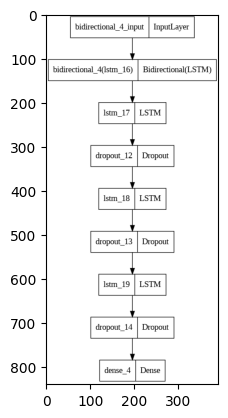

In [ ]:
plot_model(maxh_model,to_file='maxh_model.png')
img=plt.imread('maxh_model.png')
plt.imshow(img)
plt.show()

In [ ]:
#make Predictions
maxh_trainPredict = maxh_model.predict(maxh_X_train)
maxh_testPredict = maxh_model.predict(maxh_X_test)
#invert predictions
maxh_trainPredict = scaler.inverse_transform(maxh_trainPredict)
maxh_trainY = scaler.inverse_transform([maxh_y_train])
maxh_testPredict = scaler.inverse_transform(maxh_testPredict)
maxh_testY = scaler.inverse_transform([maxh_y_test])

17/17 [==============================] - 0s 3ms/step


In [ ]:
maxh_trainY = scaler.inverse_transform(maxh_y_train.reshape(-1,1))
maxh_testY = scaler.inverse_transform(maxh_y_test.reshape(-1,1))

In [ ]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(maxh_trainY,maxh_trainPredict))
print('Train Score:%.2f RMSE'%(trainScore))

testScore = math.sqrt(mean_squared_error(maxh_testY,maxh_testPredict))
print('TestScore:%.2f RMSE'%(testScore))

Train Score:5.61 RMSE
TestScore:14.22 RMSE


In [ ]:
#shift train predictions for plotting
maxh_trainPredictPlot = np.empty_like(df_maxh)
maxh_trainPredictPlot[:,:] = np.nan
maxh_trainPredictPlot[seq_size:len(maxh_trainPredict)+seq_size,:] = maxh_trainPredict
#shift test predictions for plotting
maxh_testPredictPlot = np.empty_like(df_maxh)
maxh_testPredictPlot[:,:] = np.nan
maxh_testPredictPlot[len(maxh_trainPredict)+(seq_size*2)+1:len(df_maxh)-1,:] = maxh_testPredict

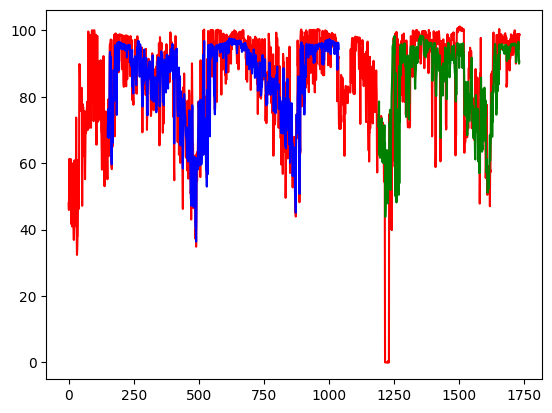

In [ ]:
plt.plot(scaler.inverse_transform(df_maxh),color='red')
plt.plot(maxh_trainPredictPlot,color='blue')
plt.plot(maxh_testPredictPlot,color='green')
plt.show()

**MAXIMUM** **WIND** **SPEED**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_maxw = scaler.fit_transform(np.array(df_maxw.reshape(-1,1)))
train_size = int(len(df_maxw)*0.60)
test_size = len(df_maxw)-train_size
maxw_train,maxw_test = df_maxw[0:train_size],df_maxw[train_size:len(df_maxw)]


seq_size = 150
maxw_trainX=[]
maxw_testX=[]

In [ ]:
maxw_trainX,maxw_y_train = to_sequences(maxw_train,seq_size)
maxw_testX,maxw_y_test = to_sequences(maxw_test,seq_size)

maxw_X_train = np.reshape(maxw_trainX,(maxw_trainX.shape[0],1,maxw_trainX.shape[1]))
maxw_X_test = np.reshape(maxw_testX,(maxw_testX.shape[0],1,maxw_testX.shape[1]))

In [ ]:
n_future = 1
feature = 2
timeSteps = 4

maxw_model = Sequential()
maxw_model.add(Bidirectional(LSTM(units=50,return_sequences=True,
                             input_shape=(maxw_X_train.shape[1],1))))
maxw_model.add(LSTM(units=50,return_sequences=True))
maxw_model.add(Dropout(0.2))
maxw_model.add(LSTM(units=50,return_sequences=True))
maxw_model.add(Dropout(0.2))
maxw_model.add(LSTM(units=50))
maxw_model.add(Dropout(0.2))
maxw_model.add(Dense(units=n_future))


maxw_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])

In [ ]:
maxw_model.fit(maxw_X_train,maxw_y_train,epochs=500)

Epoch 1/500
28/28 [==============================] - 13s 10ms/step - loss: 0.0029 - acc: 0.0652
Epoch 2/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0018 - acc: 0.0652
Epoch 3/500
28/28 [==============================] - 0s 16ms/step - loss: 0.0014 - acc: 0.0652
Epoch 4/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0012 - acc: 0.0652
Epoch 5/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0011 - acc: 0.0652
Epoch 6/500
28/28 [==============================] - 0s 16ms/step - loss: 0.0011 - acc: 0.0652
Epoch 7/500
28/28 [==============================] - 0s 15ms/step - loss: 0.0010 - acc: 0.0652
Epoch 8/500
28/28 [==============================] - 0s 14ms/step - loss: 0.0010 - acc: 0.0652
Epoch 9/500
28/28 [==============================] - 0s 15ms/step - loss: 9.8511e-04 - acc: 0.0652
Epoch 10/500
28/28 [==============================] - 0s 15ms/step - loss: 9.6337e-04 - acc: 0.0652
Epoch 11/500
28/28 [====================

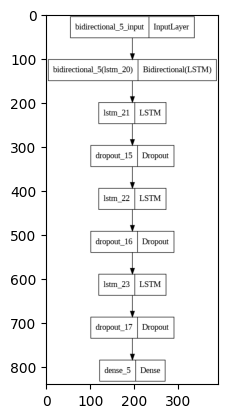

In [ ]:
plot_model(maxw_model,to_file='maxw_model.png')
img=plt.imread('maxw_model.png')
plt.imshow(img)
plt.show()

In [ ]:
#make Predictions
maxw_trainPredict = maxw_model.predict(maxw_X_train)
maxw_testPredict = maxw_model.predict(maxw_X_test)
#invert predictions
maxw_trainPredict = scaler.inverse_transform(maxw_trainPredict)
maxw_trainY = scaler.inverse_transform([maxw_y_train])
maxw_testPredict = scaler.inverse_transform(maxw_testPredict)
maxw_testY = scaler.inverse_transform([maxw_y_test])

17/17 [==============================] - 0s 4ms/step


In [ ]:
maxw_trainY = scaler.inverse_transform(maxw_y_train.reshape(-1,1))
maxw_testY = scaler.inverse_transform(maxw_y_test.reshape(-1,1))

In [ ]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(maxw_trainY,maxw_trainPredict))
print('Train Score:%.2f RMSE'%(trainScore))

testScore = math.sqrt(mean_squared_error(maxw_testY,maxw_testPredict))
print('TestScore:%.2f RMSE'%(testScore))

Train Score:0.64 RMSE
TestScore:26.80 RMSE


In [ ]:
#shift train predictions for plotting
maxw_trainPredictPlot = np.empty_like(df_maxw)
maxw_trainPredictPlot[:,:] = np.nan
maxw_trainPredictPlot[seq_size:len(maxw_trainPredict)+seq_size,:] = maxw_trainPredict
#shift test predictions for plotting
maxw_testPredictPlot = np.empty_like(df_maxw)
maxw_testPredictPlot[:,:] = np.nan
maxw_testPredictPlot[len(maxw_trainPredict)+(seq_size*2)+1:len(df_maxw)-1,:] = maxw_testPredict

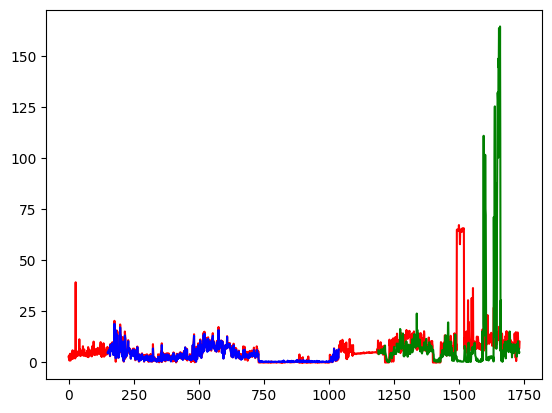

In [ ]:
plt.plot(scaler.inverse_transform(df_maxw),color='red')
plt.plot(maxw_trainPredictPlot,color='blue')
plt.plot(maxw_testPredictPlot,color='green')
plt.show()